In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# BONUS

## Importing datasets

### Emails.csv

In [2]:
mails_df = pd.read_csv('hillary-clinton-emails/Emails.csv')

print(mails_df.shape)
# print(mails_df.dtypes)
# print(mails_df.isnull().sum())
mails_df.head(3)

(7945, 22)


,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...


Chech that _every row is indeed an email_:

In [3]:
mails_df.Id.value_counts().value_counts()

1    7945
Name: Id, dtype: int64

What is missing in the _EmailReceivers.csv_ dataset, is the _sender_.  
Therefore, we investigate here that feature:

In [4]:
print('num. of non NaN:',mails_df.SenderPersonId.isnull().sum())
print('number of email sent by Clinton:',sum(mails_df.SenderPersonId==80))

num. of non NaN: 157
number of email sent by Clinton: 1993


Check also the quality (number of nan) of the CC field:

In [5]:
mails_df.ExtractedCc.isnull().sum()
mails_df.ExtractedTo.isnull().sum()

4657

### EmailReceivers.csv

In [6]:
receivers_df = pd.read_csv('hillary-clinton-emails/EmailReceivers.csv')

# remove uselss col
receivers_df.drop('Id',1,inplace=True)

# printing shape, data type and number of null values
print(receivers_df.shape)
print(receivers_df.dtypes)
print(receivers_df.isnull().sum())
receivers_df.head()

(9306, 2)
EmailId     int64
PersonId    int64
dtype: object
EmailId     0
PersonId    0
dtype: int64


,EmailId,PersonId
0,1,80
1,2,80
2,3,228
3,3,80
4,4,80


In [7]:
print('number of unique receivers:',receivers_df.PersonId.nunique())
print('number of unique emails:',receivers_df.EmailId.nunique())

# '80'  is clinton ID
print('number of emaild were clinton was recevier:',sum(receivers_df.PersonId==80))
print('number of emaild were clinton NOT was recevier - it should be:',
      receivers_df.EmailId.nunique()-sum(receivers_df.PersonId==80))

number of unique receivers: 418
number of unique emails: 7676
number of emaild were clinton was recevier: 5587
number of emaild were clinton NOT was recevier - it should be: 2089


...here we get some weird result:

In [8]:
clinton_sender = []

for m in receivers_df.EmailId.unique():
    
    if 80 not in list(receivers_df.PersonId[receivers_df.EmailId==m]):
        
        clinton_sender.append(m)
        

print('number of emails in which clinton was NOT a receiver:',len(clinton_sender))

number of emails in which clinton was NOT a receiver: 2100


Check that numbers on  clinton's emails match in the 2 datasets:  
...and they __don't__ -.-

In [9]:
sum(mails_df.SenderPersonId==80)

1993

Check that she is indeed the sender in the _Emails.csv_ dataset:

In [10]:
bad_mails = []
for m in clinton_sender:
    
    if 80 not in list(mails_df[mails_df.Id==m].SenderPersonId):
        
        bad_mails.append(m)

print('there are issues with sender for',len(bad_mails),'emails')

there are issues with sender for 151 emails


## Building the graph

### Construct adjacency matrix

Here we first try to define the graph _only_ with _EmailReceivers.csv_ dataset:  
__link weights__ = number of email shared by two recipients

We consturct the adjacency matrix using a _dictionary_ from PeronsId:

In [11]:
persons_dic = dict.fromkeys(receivers_df.PersonId.unique())

In [12]:
# 'from_dict_of_dicts' way to construct the graph

for r in persons_dic.keys():
    
    r_friends = []
    for m in receivers_df.EmailId[receivers_df.PersonId==r].unique():
        
        r_friends += list(receivers_df.PersonId[(receivers_df.EmailId==m) & (receivers_df.PersonId!=r)].unique())
        
    persons_dic[r] = r_friends

In [13]:
# remember to devide by 2, as we counted all the links 2 times!

THERE IS STILL SOMETHING WRONG! - THERE SHOULD BE NO! NODE WITH DEGREE=0

### Construct and plotting graph from adjacency matrix

In [14]:
clinton_graph = nx.from_dict_of_lists(persons_dic)

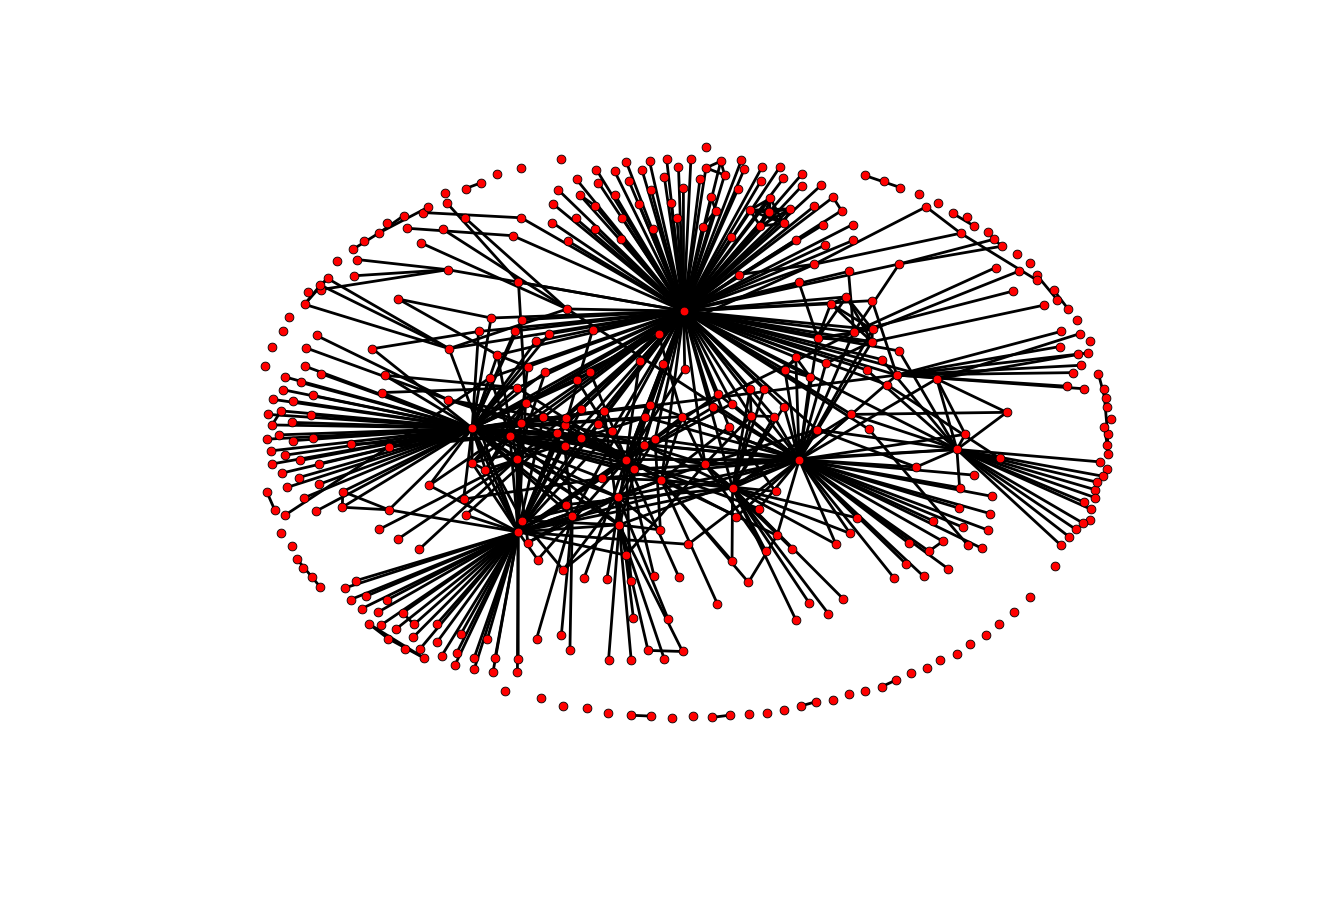

In [15]:
nx.draw_spring(clinton_graph,node_size=10)

### Some netxwork metrics

In [16]:
node_cent = pd.DataFrame()
node_cent['degree_cen'] = list(nx.degree_centrality(clinton_graph).values())
node_cent['bet_cen'] = list(nx.betweenness_centrality(clinton_graph).values())

#### You can see that degree and betwenness centralities have broad distributions...

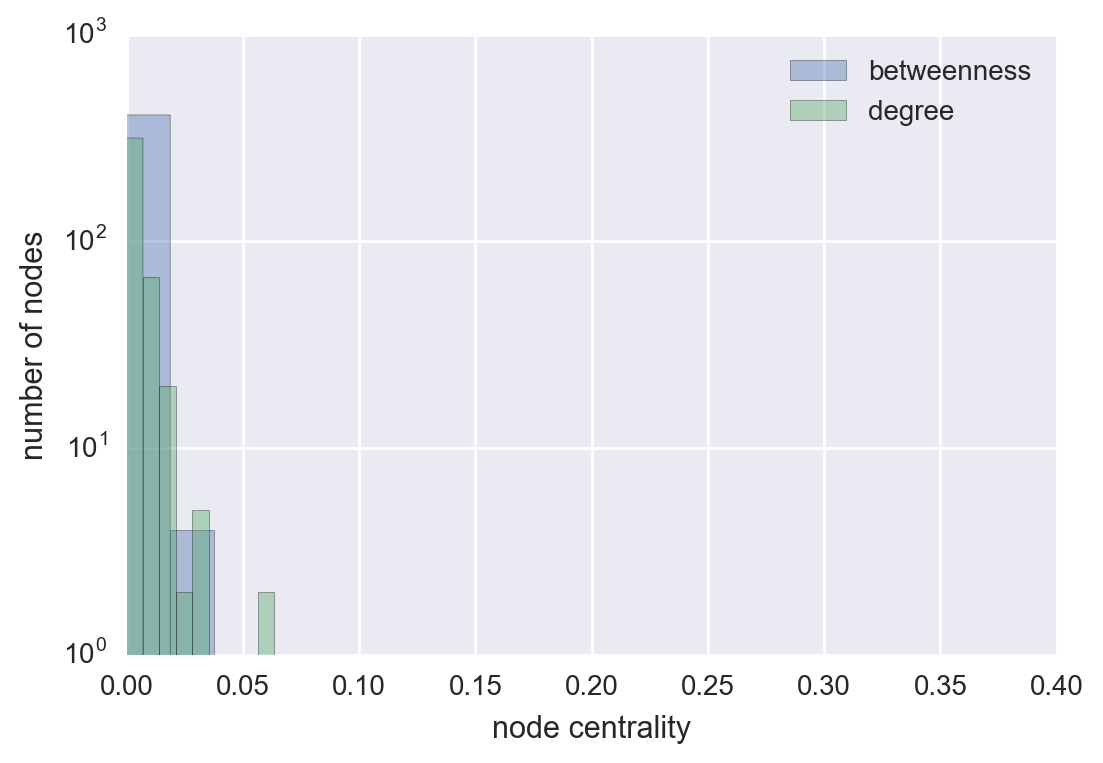

In [17]:
# plt.loglog(clinton_deg.degree_cen.value_counts(), 
#           marker= '.',linestyle='',label='degree')
# plt.loglog(clinton_bet.bet_cen.value_counts(),
#           marker= '.',linestyle='',label='betweenness')

sns.distplot(node_cent.bet_cen,label='betweenness',kde=False)
sns.distplot(node_cent.degree_cen,label='degree',kde=False)

plt.yscale('log')
# plt.xscale('log')
plt.ylabel('number of nodes')
plt.xlabel('node centrality')
plt.legend()

#### ... and they are very well correlated ( $\rho=0.97$ )  

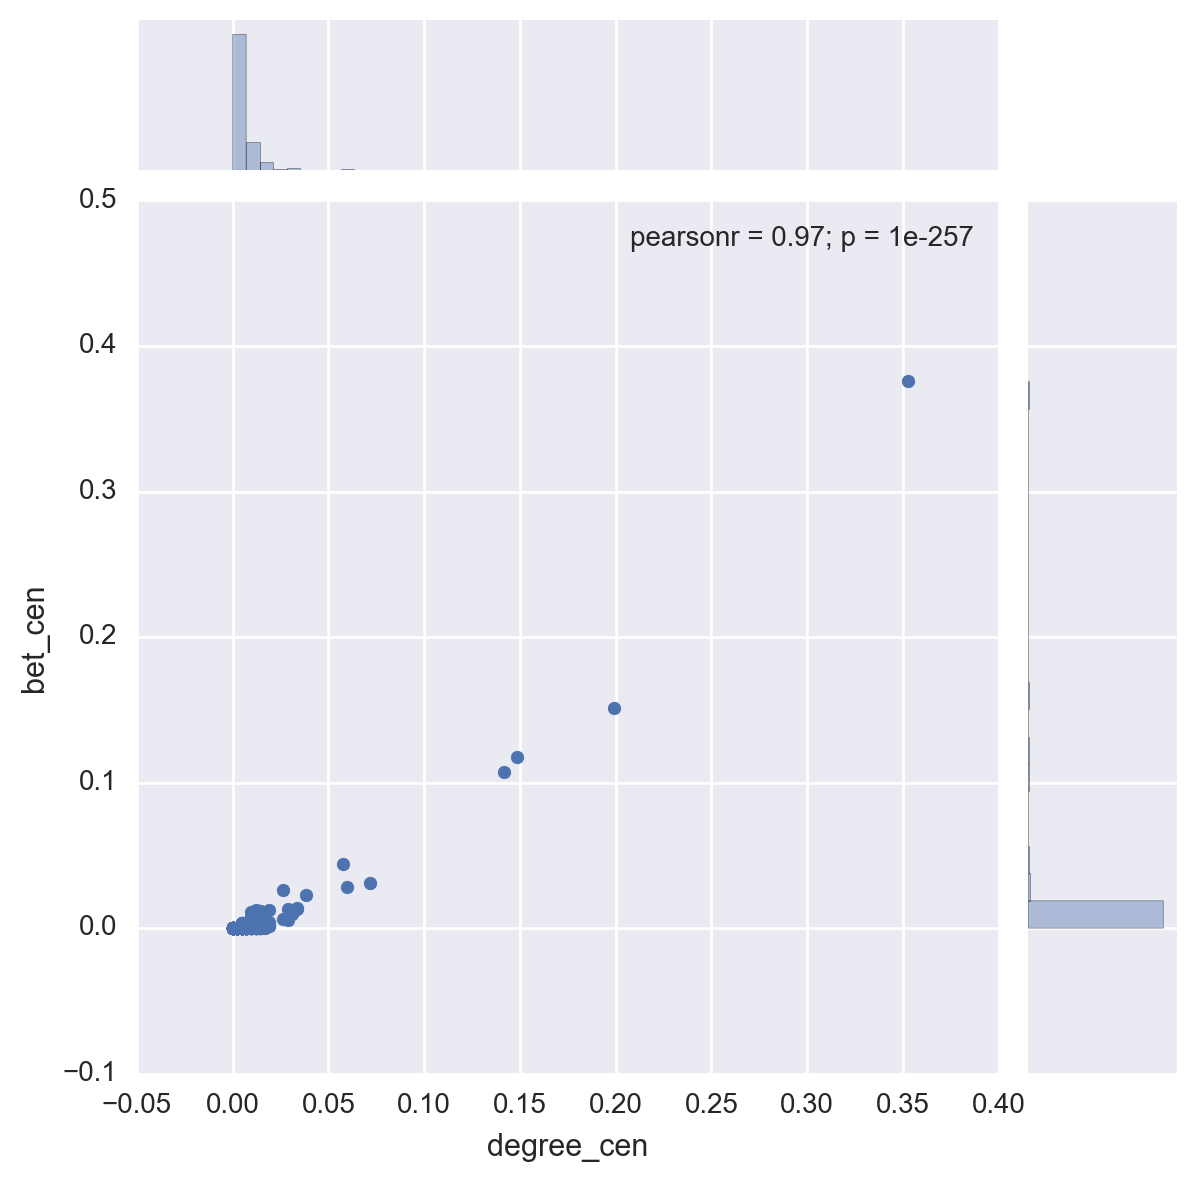

In [18]:
sns.jointplot(node_cent.degree_cen,node_cent.bet_cen)

#### Distribution of clutering coefficient:  
as we can see from the plot below, it shows a _bimodal_ shape

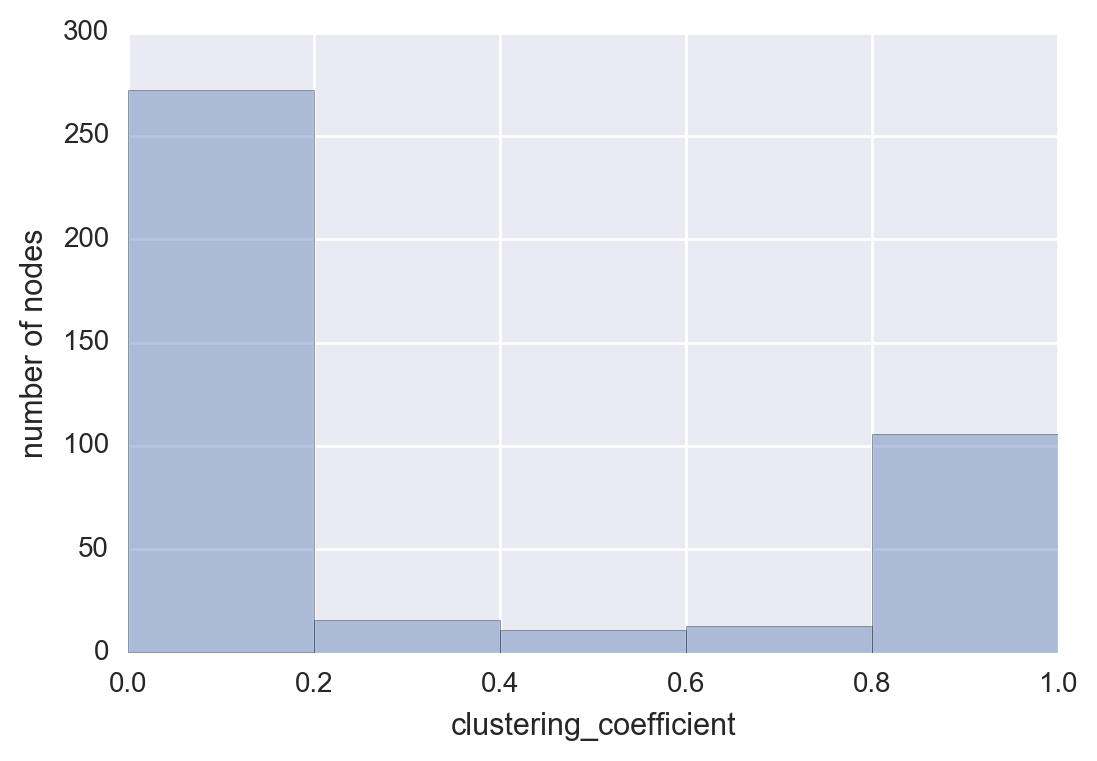

In [19]:
clinton_cc = nx.clustering(clinton_graph)

sns.distplot(list(clinton_cc.values()),kde=False)

plt.xlabel('clustering_coefficient')
plt.ylabel('number of nodes')

#### Investigate correlation between clustering coefficient and betwenness centrality:

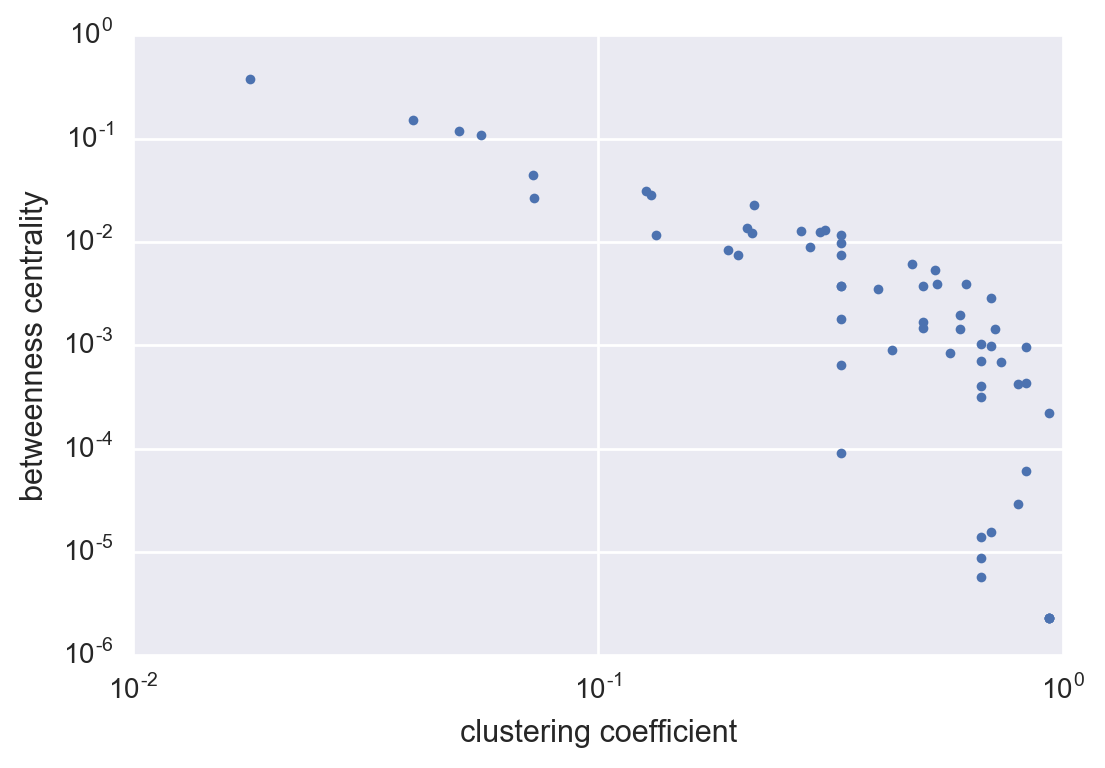

In [20]:
plt.loglog(list(clinton_cc.values()),node_cent.bet_cen,marker='.',linestyle='')

plt.xlabel('clustering coefficient')
plt.ylabel('betweenness centrality')

### Commnunity detection

In [21]:
import community

In [22]:
#first compute the best partition
partition = community.best_partition(clinton_graph)

Mind that this library (the `community` library uses the Louvain algorithm) finds:

In [23]:
print('number of communities:', len(set(partition.values())))

number of communities: 83


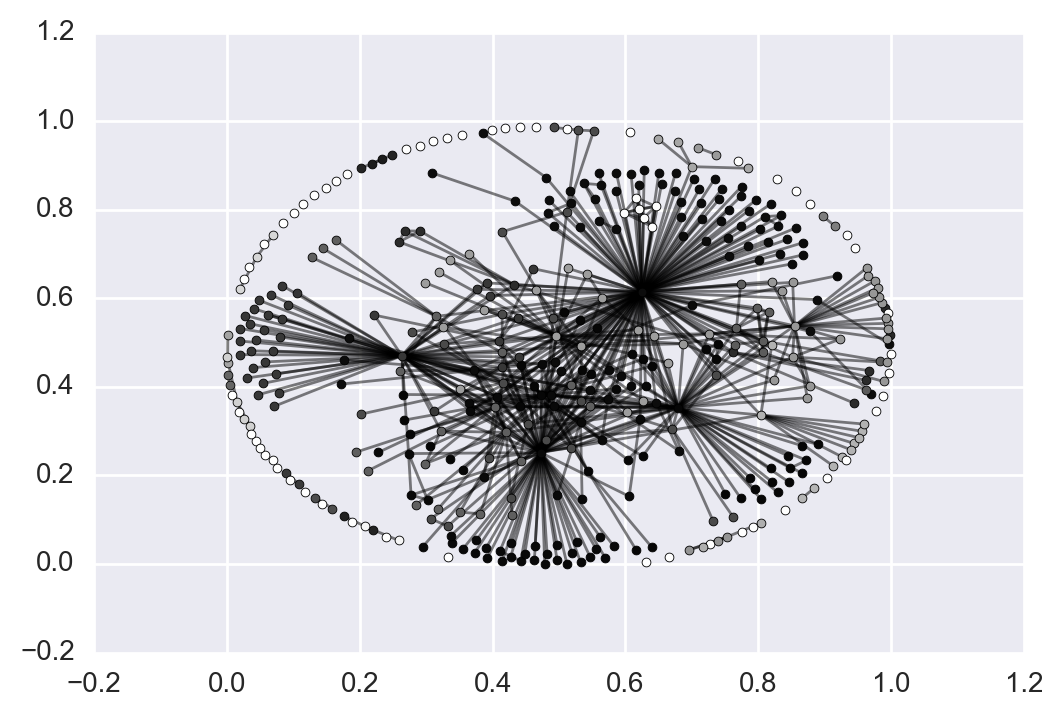

In [24]:
#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(clinton_graph)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(clinton_graph, pos, list_nodes, node_size = 10,
                                node_color = str(count / size))


nx.draw_networkx_edges(clinton_graph,pos, alpha=0.5)
plt.show()